In [1]:
# Some part borrowed from official tutorial https://github.com/pytorch/examples/blob/master/imagenet/main.py
from __future__ import print_function
from __future__ import absolute_import

import os
import numpy as np
import argparse
import importlib
import time
import logging
import warnings
from collections import OrderedDict
import pdb
import importlib

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import models
import data
import trainers
import evaluators
import attacks
from attack_vectors import get_attack_vector
from utils import *

import sklearn
from sklearn.preprocessing import normalize

import CKA

In [2]:
cifar = data.cifar10('./datasets', normalize=False)
# imagenet = data.imagenet('./datasets/imagenette2', normalize=False)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
device = "cuda:0"
in_channel = 3
num_classes = 10
config_path_1 = './configs/configs_cifar0.25.yml'
config_path_2 = './configs/configs_cifar0.5.yml'
config_path_3 = './configs/configs_cifar1.yml'
config_path_4 = './configs/configs_cifar2.yml'
# config_path = './configs/configs_imagenet.yml'
#ckpt_path = './trained_models/cifar10_WideResNet2810_base/trial_0/checkpoint/checkpoint.pth.tar'
imnet_none = './trained_models/imagenette2_ResNet18_trainadv_none/trial0/checkpoint/checkpoint.pth.tar'
imnet_linf = './trained_models/imagenette2_ResNet18_trainadv_linf/trial0/checkpoint/checkpoint.pth.tar'

In [4]:
cifar_1 = './trained_models/cifar10_ResNet18_l2_0.25/trial_0/checkpoint/checkpoint.pth.tar'
cifar_2 = './trained_models/cifar10_ResNet18_l2_0.5/trial_0/checkpoint/checkpoint.pth.tar'
cifar_3 = './trained_models/cifar10_ResNet18_l2_1/trial_0/checkpoint/checkpoint.pth.tar'
cifar_4 = './trained_models/cifar10_ResNet18_l2_2/trial_0/checkpoint/checkpoint.pth.tar'

In [5]:
imnet_model_none = torch.nn.DataParallel(models.ResNet18(in_channel=in_channel, num_classes=num_classes)).cuda().eval()
ckpt_dict5 = torch.load(imnet_none, map_location="cpu")["state_dict"]
imnet_model_none.load_state_dict(ckpt_dict5)

imnet_model_linf = torch.nn.DataParallel(models.ResNet18(in_channel=in_channel, num_classes=num_classes)).cuda().eval()
ckpt_dict6 = torch.load(imnet_linf, map_location="cpu")["state_dict"]
imnet_model_linf.load_state_dict(ckpt_dict6)

<All keys matched successfully>

In [7]:
cifar_models = []
for cifar_weights in [cifar_1, cifar_2, cifar_3, cifar_4]:
    m = torch.nn.DataParallel(models.ResNet18(in_channel=in_channel, num_classes=num_classes)).cuda().eval()
    ckpt_dict = torch.load(cifar_weights, map_location="cpu")["state_dict"]
    m.load_state_dict(ckpt_dict)
    cifar_models.append(m)

In [8]:
def get_images(imgs, test_batch=0):
    images = []
    # test_batch = 3
    for x,y in enumerate(imgs[1]):
        images.append(y)
    
    image_data = None
    image_labels = None
    for batch in range(len(images)):
        if image_data is None:
            image_data = images[batch][0]
            image_labels = images[batch][1]
        else:
            image_data = torch.cat((image_data, images[batch][0]), 0)
            image_labels = torch.cat((image_labels, images[batch][1]), 0)
    image_data = image_data.to(device)
    image_labels = image_labels.to(device)
    return images, image_data, image_labels

In [9]:
test_batch = 2
cifar_images, cifar_image_data, cifar_image_labels = get_images(cifar, test_batch)
print(cifar_image_data.shape, cifar_image_labels.shape)
# imagenet_images, imagenet_image_data, imagenet_image_labels = get_images(imagenet, test_batch)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [22]:
with open(config_path_2, 'r') as f:
    args_2 = EasyDict(yaml.load(f))

with open(config_path_3, 'r') as f:
    args_3 = EasyDict(yaml.load(f))

In [11]:
# preds_none = imnet_model_none(imagenet_image_data, all=True)
# preds_linf = imnet_model_linf(imagenet_image_data, all=True)


In [12]:
cifar_preds = []
num_images = 3000
cifar_image_data = cifar_image_data[:num_images]
cifar_image_labels = cifar_image_labels[:num_images]
for m in cifar_models:
    cifar_preds.append(m(cifar_image_data, all=True))

In [13]:
# none_activations = preds_none[1]['layer4']['block_1']['conv2'].cpu().detach().numpy()
# none_activations = np.reshape(none_activations, (128, 512 * 7 * 7))
# linf_activations = preds_linf[1]['layer4']['block_1']['conv2'].cpu().detach().numpy()
# linf_activations = np.reshape(linf_activations, (128, 512 * 7 * 7))
# print(none_activations.shape)
# print(linf_activations.shape)
# print(CKA.feature_space_linear_cka(none_activations, linf_activations))

In [17]:
cifar_activations = []
for pred in cifar_preds:
    # print(pred[1]['layer4']['block_3']['conv2'].cpu().detach().numpy().shape)
    cifar_activations.append(pred[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((num_images,512)))

In [18]:
l = len(cifar_activations)
budgets = [0.25, 0.5, 1, 2, 4, 8]
for i in range(l):
    for j in range(l):
        print(f'epsilon = {budgets[i]} vs. epsilon = {budgets[j]}')
        print(CKA.feature_space_linear_cka(cifar_activations[i], cifar_activations[j]))
    print()

epsilon = 0.25 vs. epsilon = 0.25
0.999999994142055
epsilon = 0.25 vs. epsilon = 0.5
0.9292922429210101
epsilon = 0.25 vs. epsilon = 1
0.8637460844082925
epsilon = 0.25 vs. epsilon = 2
0.8654592429728997

epsilon = 0.5 vs. epsilon = 0.25
0.9292922429210101
epsilon = 0.5 vs. epsilon = 0.5
1.0000000253950554
epsilon = 0.5 vs. epsilon = 1
0.8900220359380772
epsilon = 0.5 vs. epsilon = 2
0.9073347924873931

epsilon = 1 vs. epsilon = 0.25
0.8637462404464683
epsilon = 1 vs. epsilon = 0.5
0.8900223254114628
epsilon = 1 vs. epsilon = 1
1.0000000416071595
epsilon = 1 vs. epsilon = 2
0.88171997905948

epsilon = 2 vs. epsilon = 0.25
0.8654592429728997
epsilon = 2 vs. epsilon = 0.5
0.9073350981337917
epsilon = 2 vs. epsilon = 1
0.8817200904770877
epsilon = 2 vs. epsilon = 2
0.999999877286772



In [27]:
attack_2 = get_attack_vector('l2', args_2.EvalAttack)
attack_3 = get_attack_vector('l2', args_3.EvalAttack)

adv_images_model2_half = attack_2(cifar_models[1], cifar_image_data[:128], cifar_image_labels[:128], torch.ones((128)))
adv_images_model2_one = attack_3(cifar_models[1], cifar_image_data[:128], cifar_image_labels[:128], torch.ones((128)))
adv_images_model3_half = attack_2(cifar_models[2], cifar_image_data[:128], cifar_image_labels[:128], torch.ones((128)))
adv_images_model3_one = attack_3(cifar_models[2], cifar_image_data[:128], cifar_image_labels[:128], torch.ones((128)))

In [34]:
adv_preds_2_same = cifar_models[1](adv_images_model2_half[0], all=True)
adv_preds_2_diff = cifar_models[1](adv_images_model2_one[0], all=True)
adv_preds_3_same = cifar_models[2](adv_images_model3_one[0], all=True)
adv_preds_3_diff = cifar_models[2](adv_images_model3_half[0], all=True)

In [35]:
adv_acts_2_same = adv_preds_2_same[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((128,512))
adv_acts_2_diff = adv_preds_2_diff[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((128,512))
adv_acts_3_same = adv_preds_3_same[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((128,512))
adv_acts_3_diff = adv_preds_3_diff[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((128,512))

In [37]:
print(CKA.feature_space_linear_cka(adv_acts_2_same, adv_acts_2_diff))
print(CKA.feature_space_linear_cka(adv_acts_2_same, adv_acts_3_same))
print(CKA.feature_space_linear_cka(adv_acts_2_same, adv_acts_3_diff))
print(CKA.feature_space_linear_cka(adv_acts_2_diff, adv_acts_3_same))
print(CKA.feature_space_linear_cka(adv_acts_3_same, adv_acts_3_diff))

0.9993456477606083
0.7780997776422074
0.7920795821878492
0.7721116221825821
0.9972961360889163


In [87]:
none_activations = preds_none[1]['layer4']['block_1']['conv2'].cpu().detach().numpy()
none_activations = np.reshape(none_activations, (128, 512 * 7 * 7))
linf_activations = preds_linf[1]['layer4']['block_1']['conv2'].cpu().detach().numpy()
linf_activations = np.reshape(linf_activations, (128, 512 * 7 * 7))
print(none_activations.shape)
print(linf_activations.shape)

(128, 25088)
(128, 25088)


In [68]:
def get_weights(modules, layer, block, conv, fc=False):
    weights = []
    for i in range(len(modules)):
        if fc:
            l = modules[i]['fc']._parameters['weight']
            l = l.cpu().detach().numpy()
            weights.append(l)
        elif layer == None:
            l = modules[i]['conv1']._parameters['weight']
            l = l.cpu().detach().numpy()
            s = l.shape
            l = np.reshape(l, (s[0], s[1]*s[2]*s[3]))
            weights.append(l)
        else:
            layer_str = 'layer' + str(layer)
            conv_str = 'conv' + str(conv)

            l = modules[i][layer_str][block]._modules[conv_str]._parameters['weight']
            l = l.cpu().detach().numpy()
            s = l.shape
            l = np.reshape(l, (s[0], s[1]*s[2]*s[3]))
            weights.append(l)
    return weights

In [127]:
modules_25 = model_25._modules['module']._modules
modules_50 = model_50._modules['module']._modules
modules_1 = model_1._modules['module']._modules

modules_inone = imnet_model_none._modules['module']._modules
modules_ilinf = imnet_model_linf._modules['module']._modules

In [70]:
# conv1_weights_25 = modules_25['conv1']._parameters['weight'].cpu().detach().numpy()
# conv1_weights_50 = modules_50['conv1']._parameters['weight'].cpu().detach().numpy()
# conv1_weights_1 = modules_1['conv1']._parameters['weight'].cpu().detach().numpy()

weights = get_weights([modules_25, modules_50, modules_1],1,0,1)

print(CKA.feature_space_linear_cka(weights[0], weights[1]))
print(CKA.feature_space_linear_cka(weights[0], weights[2]))
print(CKA.feature_space_linear_cka(weights[1], weights[2]))

0.6195292849016635
0.6099217159039692
0.6115384438608529


In [133]:
for i in range(1,5):
    print('layer',i)
    for j in range(2):
        for k in range(1,3):
            weights = get_weights([modules_inone, modules_ilinf],i,j,k)
            print(CKA.feature_space_linear_cka(weights[0], weights[1]))

layer 1
0.74785792877443
0.8233991846664098
0.8815940340562435
0.8792076811292502
layer 2
0.7602707175000024
0.8946797362851782
0.9139066170873291
0.9307238326557361
layer 3
0.8500657874626262
0.9297465877018318
0.9609051733070965
0.9565875121485815
layer 4
0.9091852042100456
0.8958898495991707
0.8753909740710719
0.9028414549346199


In [71]:
fc_weights = model._modules['module']._modules['fc']._parameters['weight'].cpu().detach().numpy()
fc_weights2 = model2._modules['module']._modules['fc']._parameters['weight'].cpu().detach().numpy()

# TODO: normalize the weights
# fc_weights = normalize(fc_weights)
# fc_weights2 = normalize(fc_weights2)
CKA.feature_space_linear_cka(fc_weights, fc_weights2)

0.9956780355854683

In [ ]:
def generate_heatmap(module1, module2):
    

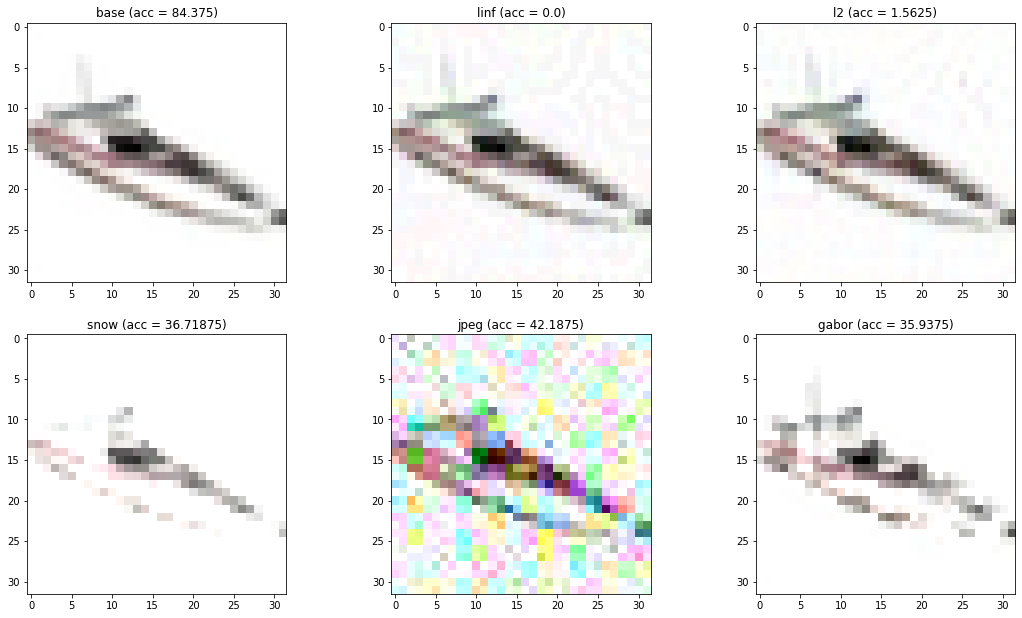

In [8]:
image = 1
attacks = ['linf','l2','snow','jpeg','gabor']
preds = model(image_data)
target = image_labels
acc = accuracy(preds, target, topk=(1,5))
f, axarr = plt.subplots(2,3)
f.set_size_inches(18.5, 10.5)
axarr[0][0].imshow(images[test_batch][0][image].transpose(0,1).transpose(1,2))
axarr[0][0].title.set_text('base (acc = ' + str(float(acc[0])) + ')')

for i in range(len(attacks)):
    attack = get_attack_vector(attacks[i], args.EvalAttack)

    adv_images = attack(model, image_data, image_labels, torch.ones_like(image_labels))

    adv_preds = model(adv_images[0])

    acc = accuracy(adv_preds, target, topk=(1,5))
    
    axarr[(i+1) // 3][(i+1) % 3].imshow(adv_images[0][image].transpose(0,1).transpose(1,2).cpu().detach())
    axarr[(i+1) // 3][(i+1) % 3].title.set_text(attacks[i] + ' (acc = ' + str(float(acc[0])) + ')')